# Chimera Movie Recommendations

## Overview

The new movie streaming service 'Cinemania' is looking for a way to increase movie streams. They have asked Chimera Solutions to provide the means of connecting subscribers to movies that they will enjoy, and then link to them to other movies that they will enjoy. The goal of this notebook is to construct a recommendation system that will accurately link subscribers to movies that fit their unique tastes

## Business Problem

Cinemania is trying to enter the highly saturated streaming service field, and is looking for the means to level the playing field. They need a recommendation system that is accurate enough to give users a reason to use their service over the many other ones.

- __Stakeholder:__ Cinemania


- __Significance of Recommendations:__ Recommendations need to be accurate so that users keep watching more and more movies on the stakeholder's streaming service


- __Deliverable:__ An interpretable Recommendation Model that the stakeholder can easily understand



## Notebook Summary 

## EDA

In [3]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader
from surprise import SVD, SVDpp, NMF, NormalPredictor, KNNBaseline, KNNBasic,\
KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering, SlopeOne
from surprise.similarities import pearson, cosine, msd
from surprise import accuracy
from surprise.model_selection import cross_validate, GridSearchCV

from sklearn.model_selection import train_test_split
from surprise.model_selection import train_test_split as sur_tts

In [4]:
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')
links = pd.read_csv('data/links.csv')
tags = pd.read_csv('data/tags.csv')

#### Movies Dataset Analysis 

In [5]:
print(movies.shape)
movies.head()

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Great! no missing values in this dataset

In [7]:
print(movies['movieId'].nunique())
print(movies['title'].nunique())

9742
9737


There are 5 duplicated Movie titles, but that is not a big deal for what we are trying to accomplish

#### Ratings Dataset Analysis

In [8]:
print(ratings.shape)
ratings.head()

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


No missing values in our ratings datset, duplicates are expected here because one user can rate multiple movies, and a movie can be rated by multiple users.

<AxesSubplot:>

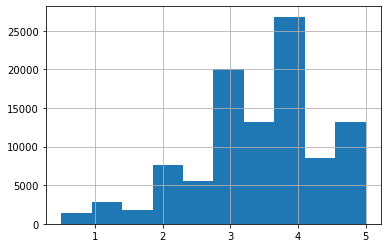

In [10]:
ratings['rating'].hist()

There seems to be a slightly skewed distribution of ratings, but this is just how users rated their movies, so this will be left as is.

In [11]:
users = ratings['userId'].nunique()
movie = ratings['movieId'].nunique()

In [12]:
print(f'There are {users} users rating {movie} movies')

There are 610 users rating 9724 movies


We have way more movies than users which is to be expected with a new streaming service. 

#### Tags Dataset Analysis

In [13]:
print(tags.shape)
tags.head()

(3683, 4)


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [14]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


No missing values and the tag column is just a user generated phrase describing something that stood out to them in the movie.

This dataset is not really important for our recommendation system

#### Links Dataset Analysis 

In [15]:
print(links.shape)
links.head()

(9742, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [16]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


After Further research into this dataset, we found that these were Id numbers that provide links to the actual movies on imdb and The Movie Database. 

This data is not needed for our recommendation system, we want users to watch movies on Cinemania's Streaming Service.

##### Data for our recommendation system

In [17]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [18]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


We are going to use the __ratings__ dataset to produce recommendations to users based on what similar users have rated highly, and we are going to use the title and genre columns from the __movies__ dataset to make the output of of our model more interpretable by using the title rather than the movieId. 

## Modeling

#### Compare Different Baseline Models

In [19]:
rating_data = ratings.drop('timestamp', axis=1)

In [20]:
reader = Reader(line_format='user item rating', sep=',')
data = Dataset.load_from_df(rating_data, reader=reader)

__Remember to Remove this markdown before submission__ This cell takes a very long time to run, this is just a note for us when going through the notebook. __do not have to run this cell__ just look at output.

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation to see which algorithms give lowest RMSE
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Create a dataframe with the algorithm as the index
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

- SVDpp, BaselineOnly, SVD, and KNNBaseline are our top 4 models with default parameeters. 
- SVDpp is only a point better but is way more computationally expensive than the other 3 seeing that it took a total of 419 seconds(7 minutes) to fit and test.

### Model Tuning

#### Split our data into a Training and Testset and train the best performing models on the training set.

In [21]:
#use sklearn library train test split
y = pd.DataFrame(rating_data['rating'])
X= rating_data.drop('rating',axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y)

#remerge to convert using reader

train_df = pd.concat([X_train,y_train],axis=1)

test_df = pd.concat([X_test,y_test],axis=1)

#convert to surprise dataframes
trainset= Dataset.load_from_df(train_df, reader=reader)

testset = Dataset.load_from_df(test_df, reader=reader)

#make testset data usable for testing

blank,testset = sur_tts(testset, test_size=.95)

type(testset)

list

In [ ]:
# use a gridsearch to find best params for SVDpp
param_grid = {'n_factors':[50,200,250],'n_epochs':[25,30,40],
              'lr_all':[.025,.05,.075],'reg_all':[.04,.05,.06]}

gs_svd = GridSearchCV(SVD,param_grid,measures=['rmse'],cv=3,n_jobs=-1)
gs_svd.fit(trainset)

params = gs_svd.best_params['rmse']

params

In [22]:
#test best SVD on testset

algo = SVD(n_factors= 200, n_epochs=30, lr_all= 0.05, reg_all= 0.05)

train_set = trainset.build_full_trainset()
algo.fit(train_set)

preds = algo.test(testset)

accuracy.rmse(preds)


RMSE: 0.8587


0.8586882938609788

In [30]:
baseline_param_grid = {'bsl_options':{'method':
['als', 'sgd'], 'n-epochs': [5, 15, 30], 
'lr_all': [0.002, 0.005, 0.01],'reg_all': [0.01, 0.2, 0.4, 0,6]}}
            

In [31]:
gs_base = GridSearchCV(BaselineOnly,baseline_param_grid,measures=['rmse'],cv=3,n_jobs=-1)
gs_base.fit(trainset)

base_params = gs_base.best_params['rmse']

base_params

{'bsl_options': {'method': 'sgd',
  'n-epochs': 5,
  'lr_all': 0.002,
  'reg_all': 0.01}}

In [32]:
base = BaselineOnly(bsl_options = {'method': 'sgd',
  'n-epochs': 5,
  'lr_all': 0.002,
  'reg_all': 0.01})
base.fit(train_set)

base_preds = base.test(testset)
accuracy.rmse(base_preds)

Estimating biases using sgd...
RMSE: 0.8684


0.8684102063999022